In [133]:
#ライブラリをインポート
import os #OSに依存する様々な機能を利用するためのモジュール(ファイルやディレクトリ操作など)
import re #正規表現を利用するためのモジュール
import csv  #csvファイルを扱うためのモジュール
import math #数学的計算のためのモジュール
from decimal import Decimal #小数点桁落ちをなくすためのモジュール
import matplotlib.pyplot as plt #グラフ描画のためのモジュール
import japanize_matplotlib #グラフ描画に日本語を用いるためのモジュール
import numpy as np  #多次元配列計算のためのモジュール
import pandas as pd #データフレームを扱うためのモジュール
from scipy import signal  #信号処理のためのモジュール
from scipy.stats import skew, kurtosis  #歪度と尖度を調べるためのモジュール
from sklearn.model_selection import train_test_split  #データをトレーニング用とテスト用に分けるためのモジュール
from sklearn import preprocessing #データを正規化するためのモジュール
from sklearn.preprocessing import StandardScaler  #データを標準化するためのモジュール
from sklearn.preprocessing import LabelEncoder  #カテゴリ変数を数値化するためのモジュール
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score #機械学習モデルの性能評価のためのモジュール
import tensorflow as tf #TensorFlow(Googleが開発したオープンソースの機械学習フレームワーク)
from tensorflow import keras  #TensorFlow用のニューラルネットワークライブラリAPI
from tensorflow.keras import layers #ニューラルネットワークのレイヤーを定義するためのモジュール

In [134]:
#Google colab用
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [135]:
#GPUを使うためのコマンド
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#よく使うgit command

#google colabと揃える
#git fetch origin main
#git reset --hard origin/main

In [136]:
#定数を定義
BINS = 4000  #ヒストグラムのビンの数
EPSILON = .00001  #スムージングパラメータ
UPPER_LIMIT = 1.1 #静止区間の上限
LOWER_LIMIT = 0.9 #静止区間の加減
STATIONARY_INTERVALS = 5  #静止区間除去のサンプルの間隔(静止区間が何サンプル連続したら除去するか)
TRAIN_SIZE = 0.8  #機械学習のトレーニングデータの割合

#transformer regression
#各種パラメータ
NUM_HEADS = 8
KEY_DIM = 500
DROPOUT = 0.1
N = 1 #Encoderのレイヤー

In [137]:
#Hascの加速度データのCSVファイルから3軸加速度を取得する関数
def get_acceleration(filename: str) -> tuple[list[float], list[float], list[float]]:
    AccX, AccY, AccZ = [], [], []
    with open(filename) as f:
        reader = csv.reader(f)
        for row in reader:
            AccX.append(float(row[1]))
            AccY.append(float(row[2]))
            AccZ.append(float(row[3]))

    return AccX, AccY, AccZ

In [138]:
#加速度データのCSVファイルから3軸加速度を取得する関数
def get_acceleration2(filename: str) -> tuple[list[float], list[float], list[float]]:
    AccX, AccY, AccZ = [], [], []
    with open(filename) as f:
        reader = csv.reader(f)
        for row in reader:
            AccX.append(float(row[2]))
            AccY.append(float(row[3]))
            AccZ.append(float(row[4]))

    return AccX, AccY, AccZ

In [139]:
#3軸合成加速度を計算する関数
def acc_to_resultant(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める
    return ResultantAcc

In [140]:
#静止区間を除去する関数(STATIONARY_INTERVALS分のみ)
def acc_to_remove_stationary_intervals(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    #各軸の加速度の平均を求める
    AvgAccX = sum(AccX) / len(AccX)
    AvgAccY = sum(AccY) / len(AccY)
    AvgAccZ = sum(AccZ) / len(AccZ)

    AvgResultantAcc = math.sqrt(AvgAccX ** 2 + AvgAccY ** 2 + AvgAccZ ** 2) #重力加速度の推定値=合成加速度の平均を求める

    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める

    #各時刻の合成加速度から静止区間(重力加速度の推定値に近い値が一定以上以上連続している区間)を除去する
    i = 0 #ループ変数
    counter = 0 #静止区間がSTATIONARY_INTERVALS分続いているかをカウントする変数
    while i < len(ResultantAcc):
        if AvgResultantAcc * LOWER_LIMIT < ResultantAcc[i] < AvgResultantAcc * UPPER_LIMIT:   #平均のLOWER_LIMIT倍~UPPER_LIMIT倍の範囲を調べる
            counter += 1    #範囲内ならカウントを増やす
            if counter == STATIONARY_INTERVALS: #カウントがSTATIONARY_INTERVALSに達したらその区間を削除
                del ResultantAcc[i+1-STATIONARY_INTERVALS:i+1]    #スライスでは選択範囲の開始位置startと終了位置stopを[start:stop]のように書くとstart <= x < stopの範囲が選択される #start番目の値は含まれるがstop番目の値は含まれない
                counter = 0 #カウンターをリセット
                i -= STATIONARY_INTERVALS   #削除した分インデックスがズレるので補正する
        else:
            counter = 0 #カウンターをリセット
        i += 1

    return ResultantAcc  #静止区間を除去した後のリストを返す

In [141]:
#静止区間を除去する関数(STATIONARY_INTERVALS以上続いた静止区間全て)
def acc_to_remove_all_stationary_intervals(AccX: list[float], AccY: list[float], AccZ: list[float]) -> list[float]:
    #各軸の加速度の平均を求める
    AvgAccX = sum(AccX) / len(AccX)
    AvgAccY = sum(AccY) / len(AccY)
    AvgAccZ = sum(AccZ) / len(AccZ)

    AvgResultantAcc = math.sqrt(AvgAccX ** 2 + AvgAccY ** 2 + AvgAccZ ** 2) #重力加速度の推定値=合成加速度の平均を求める

    ResultantAcc = [math.sqrt(x ** 2 + y ** 2 + z ** 2) for x, y, z in zip(AccX, AccY, AccZ)]   #各時刻の合成加速度を求める

    #各時刻の合成加速度から静止区間(重力加速度の推定値に近い値が一定以上以上連続している区間)を除去する
    i = 0 #ループ変数
    counter = 0 #静止区間がSTATIONARY_INTERVALS分続いているかをカウントする変数
    while i < len(ResultantAcc):
        if AvgResultantAcc * LOWER_LIMIT < ResultantAcc[i] < AvgResultantAcc * UPPER_LIMIT:   #平均のLOWER_LIMIT倍~UPPER_LIMIT倍の範囲を調べる
            counter += 1    #範囲内ならカウントを増やす
        else:
            if counter >= STATIONARY_INTERVALS:
                del ResultantAcc[i+1-counter:i+1]   #スライスでは選択範囲の開始位置startと終了位置stopを[start:stop]のように書くとstart <= x < stopの範囲が選択される #start番目の値は含まれるがstop番目の値は含まれない
                counter = 0 #カウンターをリセット
                i -= STATIONARY_INTERVALS   #削除した分インデックスがズレるので補正する
            else :
                counter = 0 #カウンターをリセット
        i += 1

    return ResultantAcc  #静止区間を除去した後のリストを返す

In [142]:
#連続する2サンプルの差分を取る関数
def calculate_differences_of_acceleration(ResultantAcc: list[float]) -> list[float]:
    DifferenceAcc = [math.fabs(Decimal(ResultantAcc[i + 1]) - Decimal(ResultantAcc[i])) for i in range(len(ResultantAcc) - 1)]  #連続する2サンプルの誤差を取る
    return DifferenceAcc

In [143]:
#入力された加速度の差分のリストからヒストグラムを作る関数（ビンの範囲が各加速度の差分データの最小値〜最大値）
def create_histogram(DifferenceAcc_list: list[float]) -> np.histogram:
    DifferenceAcc_hist = np.zeros((len(DifferenceAcc_list), BINS), dtype=float)
    for i in range(len(DifferenceAcc_list)):
        min_value = min(DifferenceAcc_list[i])
        max_value = max(DifferenceAcc_list[i])
        #DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, range=(min_value, max_value)) #ヒストグラムを作成し、同じ数のビンで区切る
        DifferenceAcc_hist[i], _ = np.histogram(DifferenceAcc_list[i], bins=BINS, density=True) #ヒストグラムを作成し、同じ数のビンで区切る
    return DifferenceAcc_hist

In [144]:
#各加速度データをダウンサンプリングする関数
def resampling_Acc(originHz: int, newHz: int, AccX: list[float], AccY: list[float], AccZ: list[float], Hz: np.array) -> tuple[list[float], list[float], list[float], np.array]:
    i = 0   #カウンター変数

    while (Hz[i] == originHz):
        originlen = len(AccX[i])    #元々のデータの長さ
        sampling_factor = int(originlen * (newHz/originHz)) #ダウンサンプリングした後のデータの長さ
        newAccX = signal.resample(AccX[i], sampling_factor)    #データをダウンサンプリング
        newAccY = signal.resample(AccY[i], sampling_factor)    #データをダウンサンプリング
        newAccZ = signal.resample(AccZ[i], sampling_factor)    #データをダウンサンプリング
        AccX.append(newAccX)   #ダウンサンプリングデータを加速度データに追加
        AccY.append(newAccY)   #ダウンサンプリングデータを加速度データに追加
        AccZ.append(newAccZ)   #ダウンサンプリングデータを加速度データに追加
        Hz = np.append(Hz, newHz)   #ダウンサンプリングレートを追加
        i += 1

    return AccX, AccY, AccZ, Hz

In [145]:
#My Transformer Model
def Transformer_Encoder_B():
      # Define the input shape
      input_shape = (BINS,)
      output_shape = (1,)

      #形を定義(このモジュールは行列でないとダメっぽい)
      inputs_encoder = layers.Input(shape=input_shape)
      #inputs_decoder = layers.Input(shape=output_shape)

      #Encoderに対する入力の形状
      x_encoder = layers.Reshape((10, 400))(inputs_encoder)

      #Transformer Encoder Layer(BERT)
      for i in range(N):
            #Multi-Head-Attention Layer
            attention_encoder = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, use_bias=True)(x_encoder, x_encoder, x_encoder)

            #Dropout Layer
            attention_encoder = layers.Dropout(rate=DROPOUT)(attention_encoder)
            #Add & Norm Layer
            attention_encoder = layers.LayerNormalization()(x_encoder + attention_encoder)

            #Feed-Forward-Network
            ffn_encoder = layers.Dense(400 * 4, use_bias=True, activation="relu")(attention_encoder)
            ffn_encoder = layers.Dense(400, use_bias=True)(ffn_encoder)

            #Dropout Layer
            ffn_encoder = layers.Dropout(rate=DROPOUT)(ffn_encoder)
            #Add & Norm Layer
            x_encoder = layers.LayerNormalization()(attention_encoder + ffn_encoder)

      x = layers.Flatten()(x_encoder)
      x = layers.Dense(128, activation="relu")(x)
      x = layers.Dropout(0.1)(x)
      x = layers.Dense(64, activation="relu")(x)
      x = layers.Dropout(0.1)(x)
      outputs = layers.Dense(1, activation="relu")(x)

      model = keras.Model(inputs=inputs_encoder, outputs=outputs)

      # Compile the model
      model.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.mean_squared_error,
            metrics=[keras.metrics.mean_squared_error],
      )

      return model

In [146]:
#My Transformer Model
def Transformer_Encoder_S():
      # Define the input shape
      input_shape = (BINS,)
      output_shape = (1,)

      #形を定義(このモジュールは行列でないとダメっぽい)
      inputs_encoder = layers.Input(shape=input_shape)
      #inputs_decoder = layers.Input(shape=output_shape)

      #Encoderに対する入力の形状
      x_encoder = layers.Reshape((1, 100))(inputs_encoder)

      #Transformer Encoder Layer(BERT)
      for i in range(N):
            #Multi-Head-Attention Layer
            attention_encoder = layers.MultiHeadAttention(num_heads=NUM_HEADS, key_dim=KEY_DIM, use_bias=True)(x_encoder, x_encoder, x_encoder)

            #Dropout Layer
            attention_encoder = layers.Dropout(rate=DROPOUT)(attention_encoder)
            #Add & Norm Layer
            attention_encoder = layers.LayerNormalization()(x_encoder + attention_encoder)

            #Feed-Forward-Network
            ffn_encoder = layers.Dense(BINS * 4, use_bias=True, activation="relu")(attention_encoder)
            ffn_encoder = layers.Dense(BINS, use_bias=True)(ffn_encoder)

            #Dropout Layer
            ffn_encoder = layers.Dropout(rate=DROPOUT)(ffn_encoder)
            #Add & Norm Layer
            x_encoder = layers.LayerNormalization()(attention_encoder + ffn_encoder)

      x = layers.Flatten()(x_encoder)
      x = layers.Dense(32, activation="relu")(x)
      x = layers.Dropout(0.1)(x)
      x = layers.Dense(16, activation="relu")(x)
      x = layers.Dropout(0.1)(x)
      outputs = layers.Dense(1, activation="relu")(x)

      model = keras.Model(inputs=inputs_encoder, outputs=outputs)

      # Compile the model
      model.compile(
            optimizer=keras.optimizers.Adam(),
            loss=keras.losses.mean_squared_error,
            metrics=[keras.metrics.mean_squared_error],
      )

      return model

In [147]:
#path(サンプリング周波数100Hzのデータ)から加速度の差分値, ヒストグラム, 正解ラベルを返す関数
def path_to_histogram(path: str) -> tuple[list[float], np.array, np.array]:
    filename = os.listdir(path) #引数のパスのディレクトリの中のファイル名一覧を取得
    #使う変数を宣言
    readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []

    #各データセットからデータを読み込み二次元配列に格納
    for i in filename:
        readAccX, readAccY, readAccZ = get_acceleration2(path+i)
        AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

    Hz = np.ones(len(filename)) * 100

    #各加速度データをダウンサンプリング
    for i in range(9, 1, -1):
        AccX, AccY, AccZ, Hz = resampling_Acc(100, i * 10, AccX, AccY, AccZ, Hz)

    #静止区間を除去
    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_remove_all_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

    #ヒストグラム作成
    for i in range(len(ResultantAcc)):
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
    DifferenceAcc_hist = create_histogram(DifferenceAcc_list)

    return DifferenceAcc_list, DifferenceAcc_hist, Hz

In [148]:
#path(サンプリング周波数100Hzのデータ)から様々な特徴量と正解ラベルを返す関数
def path_to_features(path: str) -> tuple[np.array, np.array]:
    filename = os.listdir(path) #引数のパスのディレクトリの中のファイル名一覧を取得
    #使う変数を宣言
    readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
    AccX, AccY, AccZ = [], [], []
    ResultantAcc = []
    DifferenceAcc_list = []

    #各データセットからデータを読み込み二次元配列に格納
    for i in filename:
        readAccX, readAccY, readAccZ = get_acceleration2(path+i)
        AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

    Hz = np.ones(len(filename)) * 100

    #各加速度データをダウンサンプリング
    for i in range(9, 1, -1):
        AccX, AccY, AccZ, Hz = resampling_Acc(100, i * 10, AccX, AccY, AccZ, Hz)

    features = np.ones((len(Hz), 8))    #各特徴量を入れる変数でこの関数の返り値

    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_resultant(AccX[i], AccY[i], AccZ[i]))
        features[i][0] = np.var(ResultantAcc[i])   #静止区間を除去する前の合成加速度の分散値を0列目に格納
        features[i][1] = len(ResultantAcc[i])   #静止区間を除去する前のデータの長さを1列目に格納

    #静止区間を除去
    ResultantAcc = []
    for i in range(len(Hz)):
        ResultantAcc.append(acc_to_remove_all_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

    for i in range(len(Hz)):
      features[i][2] = np.var(ResultantAcc[i])   #静止区間を除去した後の合成加速度の分散値を2列目に格納
      features[i][3] = len(ResultantAcc[i])   #静止区間を除去した後のデータの長さを3列目に格納

    #ヒストグラム作成
    for i in range(len(ResultantAcc)):
        DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
    DifferenceAcc_hist = create_histogram(DifferenceAcc_list)


    for i in range(len(Hz)):
      features[i][4] = kurtosis(DifferenceAcc_hist[i])  #標準化前のヒストグラムの尖度を4列目に格納
      features[i][5] = skew(DifferenceAcc_hist[i])  #標準化前のヒストグラムの歪度を5列目に格納

    #標準化
    scaler = StandardScaler()
    # Fit the scaler to x_train
    scaler.fit(DifferenceAcc_hist)
    # Use the scaler to transform x_train and x_test
    DifferenceAcc_hist = scaler.transform(DifferenceAcc_hist)

    for i in range(len(Hz)):
      features[i][6] = kurtosis(DifferenceAcc_hist[i])  #標準化後のヒストグラムの尖度を6列目に格納
      features[i][7] = skew(DifferenceAcc_hist[i])  #標準化後のヒストグラムの歪度を7列目に格納

    return features, Hz

In [178]:
DifferenceAcc_list, DifferenceAcc_hist, Hz = path_to_histogram("/content/drive/MyDrive/my_walk_data(100Hz15minutes)/")

In [129]:
path = "/content/drive/MyDrive/my_walk_data(100Hz15minutes)/"

In [194]:
for i in range(len(Hz)):
  print(max(DifferenceAcc_list[i]))

30527.078356125123
51317.56200632604
55729.057781794225
26589.95877783412
29506.182334101257
42169.53995757773
58286.878682004644
35457.17641294686
22205.306708620803
44620.87942342291
37019.09612778826
16689.29879436883
17236.68857723197
17817.78502513369
38490.308893022426
23504.110889132422
51744.17656905274
23369.847677692516
9996.713512803282
40444.216997132695
92278.94729332782
38591.87243506697
60233.83973543962
72817.07394937713
22702.27540672836
46938.22134434011
26326.31967585142
25181.020347556558
26424.481415041395
37296.59362675735
44015.509541906154
39922.94184306129
19311.608980676712
33562.1396640337
39502.295259796076
13405.319349647056
12228.149428106728
16294.815546844467
44009.0945968815
26996.57269758168
44823.869989319326
22999.33472895233
9692.461902067766
33646.036762536576
28340.34529655119
28544.366363764515
50614.30926269391
55574.74682359477
13625.314581841983
33931.758940860534
28833.798662749923
32890.13515455767
23646.159156998765
17468.67788926267
54093.

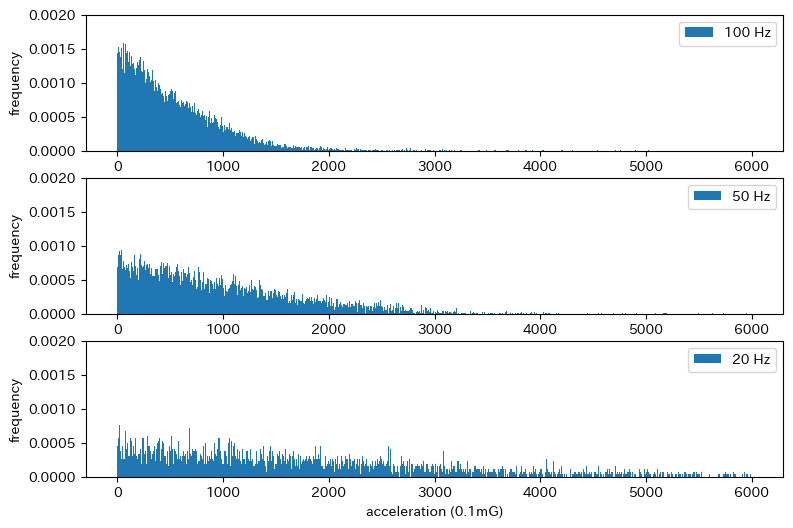

In [186]:
#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (9,6))
xl1 = "acceleration (0.1mG)"
yl1 = "frequency"

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す
ax1.hist(DifferenceAcc_list[0], bins=BINS, density=True, range=(0, 6000), label="100 Hz")
ax2.hist(DifferenceAcc_list[120], bins=BINS,density=True, range=(0, 6000), label="50 Hz")
ax3.hist(DifferenceAcc_list[192], bins=BINS,density=True, range=(0, 6000), label="20 Hz")

#各subplotにxラベルを追加
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl1)
ax3.set_xlabel(xl1)

#各subplotにyラベルを追加
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl1)
ax3.set_ylabel(yl1)

#各subplotのy軸の範囲を指定
ax1.set_ylim(0, 0.0020)
ax2.set_ylim(0, 0.0020)
ax3.set_ylim(0, 0.0020)

# 凡例表示
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper right')

plt.show()

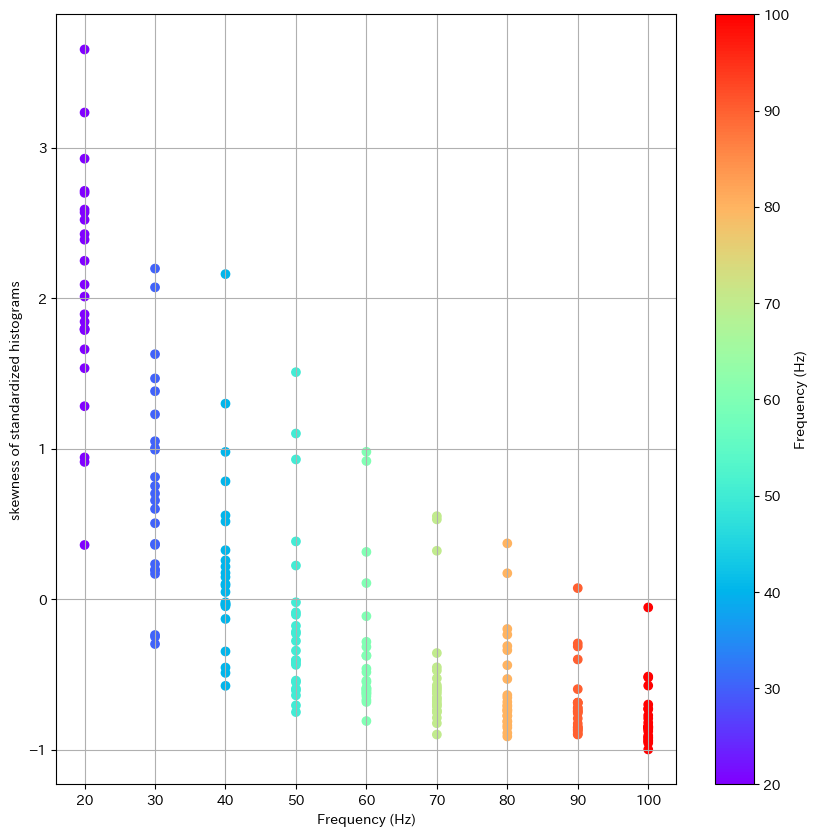

In [168]:
# クラスごとに色分けされたプロットを作成
plt.figure(figsize=(10, 10))
plt.scatter(Hz, DifferenceAcc_hist[:, ], c=Hz, cmap='rainbow', marker='o')
plt.colorbar(label='Frequency (Hz)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('skewness of standardized histograms')
#plt.ylim(-0.5, 4.5)
plt.grid(True)
plt.show()

In [ ]:
skew(DifferenceAcc_list[420])

0.692346410924036

In [ ]:
pathHascJog = "/content/drive/MyDrive/hasc(jog)/"
filename = os.listdir(pathHascJog) #引数のパスのディレクトリの中のファイル名一覧を取得
#filename.remove(".DS_Store")

In [ ]:
#使う変数を宣言
readAccX, readAccY, readAccZ = [], [], []   #データ読み込む用
AccX, AccY, AccZ = [], [], []
ResultantAcc = []
DifferenceAcc_list = []

#各データセットからデータを読み込み二次元配列に格納
for i in filename:
    readAccX, readAccY, readAccZ = get_acceleration(pathHascJog+i)
    AccX.append(readAccX), AccY.append(readAccY), AccZ.append(readAccZ)

HzHascJog = np.ones(len(filename)) * 100

#各加速度データをダウンサンプリング
for i in range(9, 1, -1):
    AccX, AccY, AccZ, HzHascJog = resampling_Acc(100, i * 10, AccX, AccY, AccZ, HzHascJog)

#静止区間を除去
for i in range(len(HzHascJog)):
    ResultantAcc.append(acc_to_remove_all_stationary_intervals(AccX[i], AccY[i], AccZ[i]))

#ヒストグラム作成
for i in range(len(ResultantAcc)):
    DifferenceAcc_list.append(calculate_differences_of_acceleration(ResultantAcc[i]))
DifferenceAcc_histHascJog = create_histogram(DifferenceAcc_list)

In [ ]:
#グラフを表示する領域を，figオブジェクトとして作成。
fig = plt.figure(figsize = (9,6))
xl1 = "acceleration (0.1mG)"
yl1 = "frequency"

#グラフを描画するsubplot領域を作成。
ax1 = fig.add_subplot(3, 1, 1)
ax2 = fig.add_subplot(3, 1, 2)
ax3 = fig.add_subplot(3, 1, 3)

#各subplot領域にデータを渡す(範囲指定)
ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, range=(0, 1), label="100 Hz")
ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, range=(0, 1), label="50 Hz")
ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, range=(0, 1), label="20 Hz")

#各subplot領域にデータを渡す
#ax1.hist(DifferenceAcc_list[0], bins=BINS,density=True, label="100 Hz")
#ax2.hist(DifferenceAcc_list[260], bins=BINS,density=True, label="50 Hz")
#ax3.hist(DifferenceAcc_list[416], bins=BINS,density=True, label="20 Hz")

#各subplotにxラベルを追加
ax1.set_xlabel(xl1)
ax2.set_xlabel(xl1)
ax3.set_xlabel(xl1)

#各subplotにyラベルを追加
ax1.set_ylabel(yl1)
ax2.set_ylabel(yl1)
ax3.set_ylabel(yl1)

#各subplotのy軸の範囲を指定
ax1.set_ylim(0, 15)
ax2.set_ylim(0, 15)
ax3.set_ylim(0, 15)

# 凡例表示
ax1.legend(loc = 'upper right')
ax2.legend(loc = 'upper right')
ax3.legend(loc = 'upper right')

plt.show()

In [180]:
stdsc = StandardScaler()
DifferenceAcc_hist = stdsc.fit_transform(DifferenceAcc_hist)

In [181]:
X_train, X_test, y_train, y_test = train_test_split(DifferenceAcc_hist, Hz, test_size = 0.2, random_state=123)

In [75]:
stdsc = StandardScaler()
# 注意
# 訓練用のデータを標準化
X_train = stdsc.fit_transform(X_train)
# 訓練用データを基準にテストデータも標準化
X_test = stdsc.transform(X_test)

In [172]:
model = Transformer_Encoder_B()

In [182]:
mae = []

In [183]:
for i in range(5):
  X_train, X_test, y_train, y_test = train_test_split(DifferenceAcc_hist, Hz, test_size = 0.2, random_state=123)
  model.fit(X_train, y_train, batch_size=16, epochs=300, shuffle=True, validation_split=0.2)
  y_pred = tf.cast(tf.clip_by_value(model.predict(X_test), 20, 100), tf.int32)
  mae.append(mean_absolute_error(y_pred, y_test))
mae

Epoch 1/300
9/9 [==============================] - 0s 20ms/step - loss: 29.8443 - mean_squared_error: 29.8443 - val_loss: 195.1434 - val_mean_squared_error: 195.1434
Epoch 2/300
9/9 [==============================] - 0s 17ms/step - loss: 25.0912 - mean_squared_error: 25.0912 - val_loss: 180.4087 - val_mean_squared_error: 180.4087
Epoch 3/300
9/9 [==============================] - 0s 16ms/step - loss: 22.2177 - mean_squared_error: 22.2177 - val_loss: 190.3267 - val_mean_squared_error: 190.3267
Epoch 4/300
9/9 [==============================] - 0s 16ms/step - loss: 24.9993 - mean_squared_error: 24.9993 - val_loss: 201.7495 - val_mean_squared_error: 201.7495
Epoch 5/300
9/9 [==============================] - 0s 17ms/step - loss: 18.3322 - mean_squared_error: 18.3322 - val_loss: 195.9483 - val_mean_squared_error: 195.9483
Epoch 6/300
9/9 [==============================] - 0s 16ms/step - loss: 27.4336 - mean_squared_error: 27.4336 - val_loss: 172.5411 - val_mean_squared_error: 172.5411
Epoc

[9.340909090909092,
 8.386363636363637,
 8.840909090909092,
 9.159090909090908,
 10.113636363636363]